In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from keras import models
from keras import layers
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import Dense, merge, Dropout, GlobalAveragePooling2D, Input
from keras.layers import Input, SeparableConv2D, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras import optimizers
from keras_preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121
from keras.applications.xception import Xception
from keras.applications import VGG16
from keras.applications import NASNetLarge, InceptionV3
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras import backend as K

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing import image
import os, shutil
from IPython.display import display
import os
import cv2
import math
import json

from hyperas.distributions import uniform
from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [19]:
bread_labels = pd.read_csv('../pet_data/breed_labels.csv')
color_labels = pd.read_csv('../pet_data/color_labels.csv')
state_labels = pd.read_csv('../pet_data/state_labels.csv')
test_sample_submission = pd.read_csv('../pet_data/test/sample_submission.csv')
test_df = pd.read_csv('../pet_data/test/test.csv')
train_df = pd.read_csv('../pet_data/train.csv')
train_folder = '../pet_data/train_images/'
test_folder = '../pet_data/test_images/'

In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2803190429046880058
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6671596257
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1090067679060682916
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:00:03.0, compute capability: 6.1"
]


In [21]:
name_target_dict = train_df.set_index('PetID')['AdoptionSpeed'].to_dict()
name_target_dict_type = train_df.set_index('PetID')['Type'].to_dict()
train_image_names = os.listdir('../pet_data/train_images')
test_image_names = os.listdir('../pet_data/test_images')

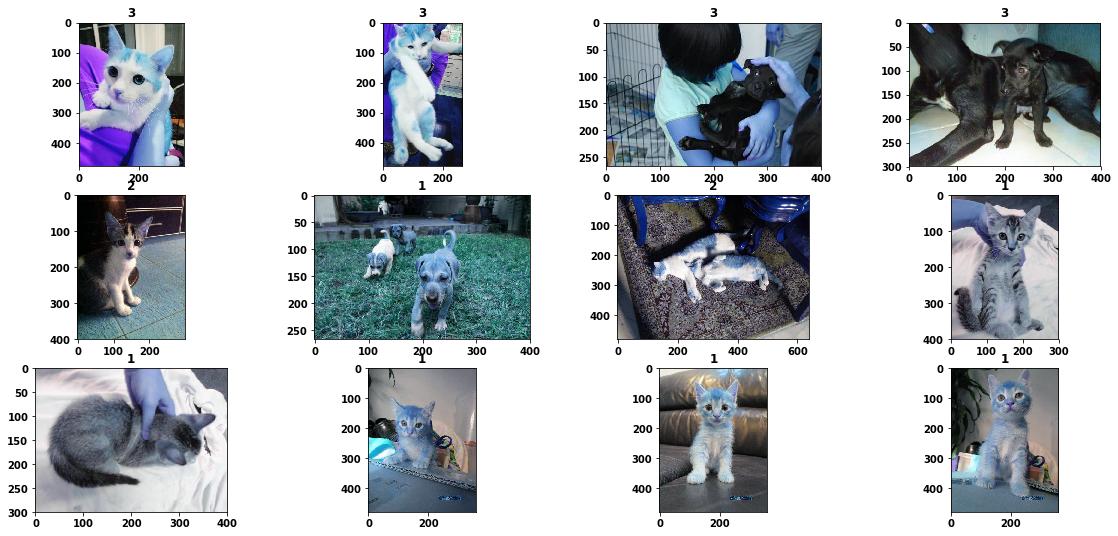

In [22]:
def display_samples(columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 3*rows))

    for i in range(columns*rows):
        image_path = train_image_names[i]
        image_id = name_target_dict[image_path.split('-')[0]]
        img = cv2.imread(f'../pet_data/train_images/{image_path}')
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)

display_samples()

In [23]:
generator_dict = {'filename': [], 'class': [], 'type': []}

for name in train_image_names:
    short_name = name.split('-')[0]
    label = name_target_dict[short_name]
    t = name_target_dict_type[short_name]
    
    generator_dict['filename'].append(name)
    generator_dict['class'].append(label)
    generator_dict['type'].append(str(t))
generator_df = pd.DataFrame(generator_dict)
generator_df.head(8)

,filename,class,type
0,0008c5398-1.jpg,3,2
1,0008c5398-5.jpg,3,2
2,000fb9572-1.jpg,3,1
3,000fb9572-3.jpg,3,1
4,0011d7c25-1.jpg,2,2
5,00156db4a-5.jpg,1,1
6,001a1aaad-1.jpg,2,2
7,001b1507c-2.jpg,1,2


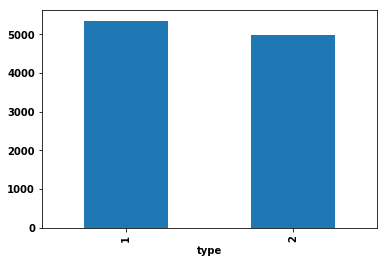

In [24]:
generator_df.groupby('type').size().plot.bar()

In [25]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[: np.newaxis]
        print('normalized confusion matrix')
    else:
        print('unnormalized confusion matrix')
        
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black'
                )
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('model accuracy')
    plt.xlabel('accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('model loss')
    plt.xlabel('loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


In [27]:
import matplotlib.image as mpimg
def show_image_predictions(probabilities, direct):
    for index, probability in enumerate(probabilities):
        image_path = direct + "/" +test_generator.filenames[index]
        img = mpimg.imread(image_path)
    #     with open(TEST_FILE,"a") as fh:
    #         fh.write(str(probability[0]) + " for: " + image_path + "\n")
        plt.imshow(img)
        if probability > 0.5:
            plt.title("%.2f" % (probability[0]*100) + "% dog in " + image_path)
        else:
            plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
        plt.show()

In [28]:
from sklearn.model_selection import train_test_split
random_state = 42
train, test = train_test_split(
    generator_df, 
    test_size=0.2, 
    random_state=random_state
)

In [29]:
def fit_model(model, model_name, epochs):
    callbacks_list = [
        ModelCheckpoint (
            filepath=model_name + '.h5', 
            monitor='val_loss', 
            verbose=0, 
            save_best_only=True, 
            save_weights_only=False,
            mode='auto',),
#         ),
#         EarlyStopping (
#             monitor='val_acc',
#             verbose=1,
#             min_delta=0.01,
#             patience=5,
#         ),
        ReduceLROnPlateau (
            monitor='val_loss',
            factor=0.1,
            verbose=1,
            cooldown=4,
            patience=10,
        ),
        TensorBoard (
            log_dir='my_log_dir',
            embeddings_freq=0,
            write_graph=True
        ),
    ]
    

    STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size


    return model.fit_generator(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN, 
        epochs=epochs,
        callbacks=callbacks_list,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,
        verbose=1
    )

In [30]:
def prediction_results(model):
    test_datagen=ImageDataGenerator(rescale=1./255.)
    # cut off the last 3 rows as it messes 
    # with the predictions due to the batch size not dividing evenly
    test_mod = test[:-3]
    test_generator = test_datagen.flow_from_dataframe(
            test_mod, 
            '../pet_data/train_images/', 
            x_col='filename',
            y_col=None, 
            target_size=(150, 150),
            class_mode=None, 
            color_mode='rgb',
            batch_size=16, 
            shuffle=False,
            seed=2018,
        )

    STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

    test_generator.reset()
    drop_pred5=model.predict_generator(
        test_generator,
        STEP_SIZE_TEST,
        verbose=1
    )
    prediction_dict = {'filename': [], 'prediction': []}
    df = pd.DataFrame()

    for index, predict in enumerate(drop_pred5):
        filename = test_generator.filenames[index]
        if predict > 0.5:
            prediction_dict['filename'].append(filename) 
            prediction_dict['prediction'].append(2) 
        else: 
            prediction_dict['filename'].append(filename) 
            prediction_dict['prediction'].append(1)

    predictions_df5 = pd.DataFrame(prediction_dict) 

    drop_y_true5 = test_mod.type.astype(int)
    drop_y_pred5 = predictions_df5.prediction

    plot_confusion_matrix(
        confusion_matrix(drop_y_true5, drop_y_pred5),
        ['cat', 'dog']
    )

    report = classification_report(
        drop_y_true5, 
        drop_y_pred5, 
        [1, 2]
    )
    print(report) 

In [31]:
def validation_scores(model):
    # model.load_weights('model.h5')

    drop_val_scores5 = model.evaluate_generator(
        valid_generator,
        STEP_SIZE_VALID,
        verbose=1,
    )

    print('Validation loss:', drop_val_scores5[0])
    print('Validation accuracy:', drop_val_scores5[1])

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('model accuracy')
    plt.xlabel('accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('model loss')
    plt.xlabel('loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Augmentation

In [33]:

train_datagen=ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    shear_range=0.1,  # set range for random shear
    zoom_range=0.1,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=1/255.,
    # set function that will be applied on each input
    preprocessing_function=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.1
)

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

Found 7438 images belonging to 2 classes.
Found 826 images belonging to 2 classes.


In [34]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size


In [35]:
vgg = models.Sequential()

vgg.add(layers.Conv2D(64, (3, 3), activation='relu', 
                      input_shape=(150, 150, 3), padding='same'))
vgg.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
vgg.add(layers.BatchNormalization())
vgg.add(layers.MaxPooling2D((2, 2)))

vgg.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg.add(layers.BatchNormalization())
vgg.add(layers.MaxPooling2D((2, 2)))

vgg.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg.add(layers.BatchNormalization())
vgg.add(layers.MaxPooling2D((2, 2)))

vgg.add(layers.Flatten())
vgg.add(layers.Dropout(0.5))
vgg.add(layers.Dense(256, activation='relu'))
vgg.add(layers.BatchNormalization())

vgg.add(layers.Dense(1, activation='sigmoid'))

# vgg.compile(loss='binary_crossentropy',
#               optimizer=optimizers.RMSprop(lr=1e-4),
#               metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [36]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 128)       512       
__________

In [33]:
# vgg3 = vgg

# vgg3.compile(loss='binary_crossentropy',
#               optimizer='Adam',
#               metrics=['acc'])

Epoch 1/100
464/464 [==============================] - 91s 196ms/step - loss: 0.6043 - acc: 0.6923 - val_loss: 0.9191 - val_acc: 0.5630
Epoch 2/100
464/464 [==============================] - 88s 191ms/step - loss: 0.5054 - acc: 0.7519 - val_loss: 0.6532 - val_acc: 0.6272
Epoch 3/100
464/464 [==============================] - 89s 191ms/step - loss: 0.4919 - acc: 0.7621 - val_loss: 0.5282 - val_acc: 0.7444
Epoch 4/100
464/464 [==============================] - 88s 191ms/step - loss: 0.4744 - acc: 0.7703 - val_loss: 1.1082 - val_acc: 0.4914
Epoch 5/100
464/464 [==============================] - 88s 190ms/step - loss: 0.4469 - acc: 0.7883 - val_loss: 0.8569 - val_acc: 0.4951
Epoch 6/100
464/464 [==============================] - 88s 190ms/step - loss: 0.4868 - acc: 0.7615 - val_loss: 0.7256 - val_acc: 0.6173
Epoch 7/100
464/464 [==============================] - 88s 190ms/step - loss: 0.4158 - acc: 0.8092 - val_loss: 0.4528 - val_acc: 0.7877
Epoch 8/100
464/464 [===========================

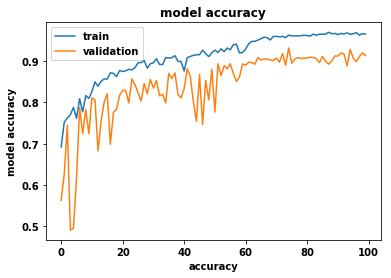

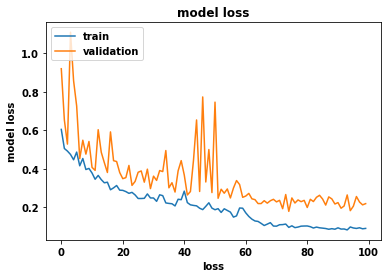

51/51 [==============================] - 8s 154ms/step
Validation loss: 0.2112577524634055
Validation accuracy: 0.9148148148148149
Found 2064 images.
129/129 [==============================] - 9s 67ms/step
unnormalized confusion matrix
[[1003   77]
 [ 100  884]]
              precision    recall  f1-score   support

           1       0.91      0.93      0.92      1080
           2       0.92      0.90      0.91       984

   micro avg       0.91      0.91      0.91      2064
   macro avg       0.91      0.91      0.91      2064
weighted avg       0.91      0.91      0.91      2064



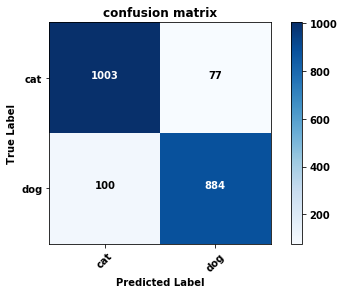

In [34]:
# vgg3_plot = fit_model(vgg3, 'my_vgg3', 100)
# plot_history(vgg3_plot)
# validation_scores(vgg3)
# prediction_results(vgg3)

In [38]:
def data():
    test_df = pd.read_csv('../pet_data/test/test.csv')
    train_df = pd.read_csv('../pet_data/train.csv')
    train_folder = '../pet_data/train_images/'
    test_folder = '../pet_data/test_images/'
    name_target_dict = train_df.set_index('PetID')['AdoptionSpeed'].to_dict()
    name_target_dict_type = train_df.set_index('PetID')['Type'].to_dict()
    train_image_names = os.listdir('../pet_data/train_images')
    test_image_names = os.listdir('../pet_data/test_images')
    generator_dict = {'filename': [], 'class': [], 'type': []}

    for name in train_image_names:
        short_name = name.split('-')[0]
        label = name_target_dict[short_name]
        t = name_target_dict_type[short_name]

        generator_dict['filename'].append(name)
        generator_dict['class'].append(label)
        generator_dict['type'].append(str(t))
        
    generator_df = pd.DataFrame(generator_dict)
    generator_df.head(8)
    
    random_state = 42
    train, test = train_test_split(generator_df, test_size=0.2, random_state=random_state)
    
    train_datagen=ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        shear_range=0.1,  # set range for random shear
        zoom_range=0.1,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=1/255.,
        # set function that will be applied on each input
        preprocessing_function=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.1
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset='training'
    )
    valid_generator = train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset='validation'
    )
    
    return train_generator, valid_generator, train, test

In [60]:
def model(train_generator, valid_generator):
    input_shape=(150, 150, 3)
    ks1_first = {{choice([2, 3, 4, 5, 8, 10])}}
    ks1_second = {{choice([2, 3, 4, 5, 8, 10])}}
    
    ks2_first = {{choice([2, 3, 4, 5, 8, 10])}}
    ks2_second = {{choice([2, 3, 4, 5, 8, 10])}}
    pool = {{choice([2, 4])}}
    
    
    model = models.Sequential()

    model.add(Conv2D(filters=( {{choice([32, 64, 128])}} ), 
                                    kernel_size=(ks1_first, ks1_second), 
                                    activation='relu', 
                                    input_shape=input_shape, 
                                    padding='same'))
    model.add(Conv2D(filters=( {{choice([32, 64, 128])}} ),
                                     kernel_size=(ks1_first, ks1_second),
                                     activation='relu', 
                                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool, pool))

    model.add(Conv2D(filters=( {{choice([64, 128, 256])}} ),
                                     kernel_size=(ks2_first, ks2_second),
                                     activation='relu', 
                                     padding='same'))
    model.add(Conv2D(filters=( {{choice([64, 128, 256])}}) ,
                                     kernel_size=(ks2_first, ks2_second),
                                     activation='relu', 
                                     padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool, pool))

    model.add(Conv2D(filters=( {{choice([32, 64, 128])}}) ,
                                     kernel_size=(ks2_first, ks2_second),
                                     activation='relu', 
                                     padding='same'))
    model.add(Conv2D(filters=( {{choice([32, 64, 128])}}) ,
                                     kernel_size=(ks2_first, ks2_second),
                                     activation='relu', 
                                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool, pool))

    model.add(Flatten())
    model.add(Dropout( {{uniform(0, 1)}} ))
    model.add(Dense ({{choice([32, 64, 128, 256, 512, 1024, 2048, 4096])}} ,
                            activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer={{choice([
                      optimizers.RMSprop(lr=1e-4),
                      'RMSprop',
                      'Adam',
                      'adadelta',
                      'adagrad',
                      'nadam'
                  ])}},
                  metrics=['acc'])
              
    callbacks_list = [
        ModelCheckpoint (
            filepath='best.h5', 
            monitor='val_loss', 
            verbose=0, 
            save_best_only=True, 
            save_weights_only=False,
            mode='auto',
        ),
        EarlyStopping (
            monitor='val_acc',
            verbose=1,
            min_delta=0.01,
            patience=10,
        ),
        ReduceLROnPlateau (
            monitor='val_loss',
            factor=0.1,
            verbose=1,
            cooldown=4,
            patience=10,
        ),
        TensorBoard (
            log_dir='my_log_dir',
            embeddings_freq=0,
            write_graph=True
        ),
    ]
                  
    checkpoint = ModelCheckpoint(
        'vgg_with_hyperas.h5', 
        monitor='val_acc', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False,
        mode='auto'
    )

    STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

    result = model.fit_generator(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN, 
        epochs=100,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,
        callbacks=callbacks_list,
        verbose=0
    )
    
    val_acc = np.amin(result.history['val_acc'])
    print('Best validation accuracy of epoch:', val_acc)
    
    return {'val_acc': -val_acc, 'status': STATUS_OK, 'model': model}

In [61]:
best_run, best_model = optim.minimize(
    model=model, 
    data=data,
    algo=tpe.suggest,
    max_evals=5,
    eval_space=True,
    trials=Trials(),
    notebook_name='Train cat dog classifier best model with Hyperas'
)
    
X_train, y_train, X_test, y_test = data()
print("Evalutation of best performing model:")
# print(best_model.evaluate(valid))

print("Crossvalidation of best performing model:")
#print(best_model.evaluate(X_test, y_test))

print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from scipy import ndimage
except:
    pass

try:
    from keras import models
except:
    pass

try:
    from keras import layers
except:
    pass

try:
    from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
except:
    pass

try:
    from keras.layers import Dense, merge, Dropout, GlobalAveragePooling2D, Input
except:
    pass

try:
    from keras.layers import Input, SeparableConv2D, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
except:
    pass

try:
    from keras import optimizers
except:
    pass

try:
    from keras_preprocessing.image import ImageDataGenerator
except:
    pass

try:
    import keras
except:
    pass

try:
    from keras.callbacks import ModelCheckpoint,

 115: 
Found 7438 images belonging to 2 classes.
Found 826 images belonging to 2 classes.
                                                   
Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 00014: early stopping                        
Best validation accuracy of epoch:                 
0.41111111140545503                                
Epoch 00054: early stopping                                                       
Best validation accuracy of epoch:                                                  
0.454320987654321                                                                   
                                                                                    
Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 00058: early stopping                                                       
Best validation accuracy of epoch:                                                
0.5617283949145564                  

In [64]:
def model2(train_generator, valid_generator):
    input_shape=(150, 150, 3)
    ks1_first = {{choice([2, 3, 4, 5, 8, 10])}}
    ks1_second = {{choice([2, 3, 4, 5, 8, 10])}}
    
    ks2_first = {{choice([2, 3, 4, 5, 8, 10])}}
    ks2_second = {{choice([2, 3, 4, 5, 8, 10])}}
    pool = {{choice([2, 4])}}
    
    
    model = models.Sequential()

    model.add(Conv2D(filters=( {{choice([32, 64, 128])}} ), 
                                    kernel_size=(ks1_first, ks1_second), 
                                    activation='relu', 
                                    input_shape=input_shape, 
                                    padding='same'))
    model.add(Conv2D(filters=( {{choice([32, 64, 128])}} ),
                                     kernel_size=(ks1_first, ks1_second),
                                     activation='relu', 
                                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool, pool))

    model.add(Conv2D(filters=( {{choice([64, 128, 256])}} ),
                                     kernel_size=(ks2_first, ks2_second),
                                     activation='relu', 
                                     padding='same'))
    model.add(Conv2D(filters=( {{choice([64, 128, 256])}}) ,
                                     kernel_size=(ks2_first, ks2_second),
                                     activation='relu', 
                                     padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool, pool))

    model.add(Conv2D(filters=( {{choice([32, 64, 128])}}) ,
                                     kernel_size=(ks2_first, ks2_second),
                                     activation='relu', 
                                     padding='same'))
    model.add(Conv2D(filters=( {{choice([32, 64, 128])}}) ,
                                     kernel_size=(ks2_first, ks2_second),
                                     activation='relu', 
                                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool, pool))

    model.add(Flatten())
    model.add(Dropout( {{uniform(0, 1)}} ))
    model.add(Dense ({{choice([32, 64, 128, 256, 512, 1024, 2048, 4096])}} ,
                            activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer={{choice([
                      optimizers.RMSprop(lr=1e-4),
                      'rmsprop',
                      'adam',
                      'adadelta',
                      'adagrad',
                      'nadam'
                  ])}},
                  metrics=['acc'])
              
    callbacks_list = [
        ModelCheckpoint (
            filepath='best.h5', 
            monitor='val_loss', 
            verbose=0, 
            save_best_only=True, 
            save_weights_only=False,
            mode='auto',
        ),
        EarlyStopping (
            monitor='val_acc',
            verbose=1,
            min_delta=0.01,
            patience=10,
        ),
        ReduceLROnPlateau (
            monitor='val_loss',
            factor=0.1,
            verbose=1,
            cooldown=4,
            patience=10,
        ),
        TensorBoard (
            log_dir='my_log_dir',
            embeddings_freq=0,
            write_graph=True
        ),
    ]
                  
    checkpoint = ModelCheckpoint(
        'vgg_with_hyperas.h5', 
        monitor='val_acc', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False,
        mode='auto'
    )

    STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

    result = model.fit_generator(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN, 
        epochs=100,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,
        callbacks=callbacks_list,
        verbose=0
    )
    
    val_acc = np.amin(result.history['val_acc'])
    print('Best validation accuracy of epoch:', val_acc)
    
    return {'loss': -val_acc, 'status': STATUS_OK, 'model': model}

In [65]:
best_run, best_model = optim.minimize(
    model=model2, 
    data=data,
    algo=tpe.suggest,
    max_evals=10,
    eval_space=True,
    trials=Trials(),
    notebook_name='Train cat dog classifier best model with Hyperas'
)
    
X_train, y_train, X_test, y_test = data()
print("Evalutation of best performing model:")
# print(best_model.evaluate(valid))

print("Crossvalidation of best performing model:")
#print(best_model.evaluate(X_test, y_test))

print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from scipy import ndimage
except:
    pass

try:
    from keras import models
except:
    pass

try:
    from keras import layers
except:
    pass

try:
    from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
except:
    pass

try:
    from keras.layers import Dense, merge, Dropout, GlobalAveragePooling2D, Input
except:
    pass

try:
    from keras.layers import Input, SeparableConv2D, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
except:
    pass

try:
    from keras import optimizers
except:
    pass

try:
    from keras_preprocessing.image import ImageDataGenerator
except:
    pass

try:
    import keras
except:
    pass

try:
    from keras.callbacks import ModelCheckpoint,

 115: 
Found 7438 images belonging to 2 classes.
Found 826 images belonging to 2 classes.
                                                    
Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 00023: early stopping                         
Best validation accuracy of epoch:                  
0.4691358027634797                                  
Epoch 00047: early stopping                                                       
Best validation accuracy of epoch:                                                  
0.5839506175782946                                                                  
Epoch 00058: early stopping                                                         
Best validation accuracy of epoch:                                                  
0.4654320987654321                                                                  
Epoch 00052: early stopping                                                         
Best validation accuracy

In [67]:
input_shape=(150, 150, 3)

hyperas_model = models.Sequential()

hyperas_model.add(Conv2D(filters=(64), 
                                    kernel_size=(5, 2), 
                                    activation='relu', 
                                    input_shape=input_shape, 
                                    padding='same'))
hyperas_model.add(Conv2D(filters=(128),
                                 kernel_size=(5, 2),
                                 activation='relu', 
                                 padding='same'))
hyperas_model.add(BatchNormalization())
hyperas_model.add(MaxPooling2D(2, 2))


hyperas_model.add(Conv2D(filters=(64),
                                 kernel_size=(5, 3),
                                 activation='relu', 
                                 padding='same'))
hyperas_model.add(Conv2D(filters=(128) ,
                                 kernel_size=(5, 3),
                                 activation='relu', 
                                 padding='same'))
hyperas_model.add(layers.BatchNormalization())
hyperas_model.add(layers.MaxPooling2D(2, 2))

hyperas_model.add(Conv2D(filters=(128) ,
                                 kernel_size=(5, 3),
                                 activation='relu', 
                                 padding='same'))
hyperas_model.add(Conv2D(filters=(32) ,
                                 kernel_size=(5, 3),
                                 activation='relu', 
                                 padding='same'))
hyperas_model.add(BatchNormalization())
hyperas_model.add(MaxPooling2D(2, 2))

hyperas_model.add(Flatten())
hyperas_model.add(layers.Dropout(0.4970559482092457))
hyperas_model.add(layers.Dense(1024, activation='relu'))
hyperas_model.add(layers.BatchNormalization())

hyperas_model.add(layers.Dense(1, activation='sigmoid'))

hyperas_model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

In [68]:
hyperas_model_plot = fit_model(hyperas_model, 'hyperas_model', 100)
plot_history(hyperas_model)
validation_scores(hyperas_model)
prediction_results(hyperas_model)

Epoch 1/100
 15/464 [..............................] - ETA: 24:57 - loss: 0.7396 - acc: 0.50 - ETA: 15:48 - loss: 1.3543 - acc: 0.46 - ETA: 11:58 - loss: 1.6676 - acc: 0.43 - ETA: 10:37 - loss: 2.1507 - acc: 0.45 - ETA: 9:50 - loss: 2.6372 - acc: 0.4500 - ETA: 9:18 - loss: 2.9922 - acc: 0.416 - ETA: 8:56 - loss: 2.9436 - acc: 0.437 - ETA: 8:41 - loss: 2.8073 - acc: 0.484 - ETA: 8:27 - loss: 2.8095 - acc: 0.493 - ETA: 8:18 - loss: 2.8960 - acc: 0.481 - ETA: 8:14 - loss: 2.8693 - acc: 0.488 - ETA: 8:06 - loss: 2.8056 - acc: 0.494 - ETA: 8:02 - loss: 2.6659 - acc: 0.509 - ETA: 7:57 - loss: 2.6869 - acc: 0.504 - ETA: 7:51 - loss: 2.6423 - acc: 0.5125

KeyboardInterrupt: 